<a href="https://colab.research.google.com/github/prateekwalia31/Appointment_Cancelation_Prediction/blob/main/Appointment_Cancelation_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Dependencies and Reading CSV data as Panda's DataFrame


In [ ]:
#Importing all dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import SCORERS
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import zipfile


In [ ]:
#Note: For compiling the Notebook again please include the Data zip folder in the /content/ folder of colab workspace

zf = zipfile.ZipFile('/content/Assignment 11.zip') 
print(zf.namelist())

['Assignment 1/MedicalCentre.csv', 'Assignment 1/MedicalCentre.xlsx', 'Assignment 1/IAI5101 Assignment 1.pdf']


In [ ]:
#Creating a Pandas DataFrame using read_csv methods from Pandas.

df = pd.read_csv(zf.open('Assignment 1/MedicalCentre.csv'), dtype={'PatientID': 'float', 'Age': 'Int64'})

In [ ]:
df.sample(n=5)

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
12333,4.690000e+12,5730765,F,2016-05-24T09:06:12Z,2016-05-24T00:00:00Z,82,PRAIA DO CANTO,0,1,0,0,0,0,No
51796,5.470000e+13,5709388,M,2016-05-17T13:39:16Z,2016-05-18T00:00:00Z,40,INHANGUETÁ,0,0,0,0,0,0,Yes
100923,6.590000e+12,5773278,M,2016-06-06T07:03:15Z,2016-06-08T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,0,Yes
48188,6.392484e+09,5656101,F,2016-05-04T07:36:52Z,2016-05-06T00:00:00Z,54,SÃO JOSÉ,0,1,1,0,0,0,Yes
33382,3.288297e+10,5608320,F,2016-04-20T13:36:50Z,2016-05-18T00:00:00Z,15,SANTA MARTHA,0,0,0,0,0,0,No


#Data Cleaning and Preparation

Removing Duplicates

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.duplicated(subset=['AppointmentID']).sum() #As no appointment Id is duplicated this means all appointments are different and no duplicated data is present.

0

Missing or Null values.

In [ ]:
df.isnull().sum()

PatientID         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               3
Neighbourhood     0
Scholarship       0
Hypertension      0
Diabetes          0
Alcoholism        0
Handicap          0
SMS_received      0
No-show           0
dtype: int64

Three missing values found in the Age Feature

In [ ]:
#Replacing the three missing Age Values with the rounded mean of the Age feature

missing_age_idx = df[df['Age'].isnull()].index.tolist()
print("Missing age values found at index:\n",df['Age'][missing_age_idx])


Missing age values found at index:
 14    <NA>
29    <NA>
80    <NA>
Name: Age, dtype: Int64


In [ ]:
df['Age'].fillna(int(round(df['Age'].mean())), inplace=True)

In [ ]:
df.isnull().sum()

PatientID         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hypertension      0
Diabetes          0
Alcoholism        0
Handicap          0
SMS_received      0
No-show           0
dtype: int64

In [ ]:
print("Replaced age values:\n",df['Age'][missing_age_idx])

Replaced age values:
 14    37
29    37
80    37
Name: Age, dtype: Int64


In [ ]:
df.isnull().sum()

PatientID         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hypertension      0
Diabetes          0
Alcoholism        0
Handicap          0
SMS_received      0
No-show           0
dtype: int64

Here the data is clean from duplicate and missing values.

#Feature Engineering


Separating Date and Time features.

In [ ]:
#Creating separate date and time into two different features.

df['ScheduledDate'] = pd.to_datetime(df.ScheduledDay, format='%Y-%m-%d')

df['ScheduledTime'] = pd.to_datetime(df['ScheduledDay']).dt.time

df['AppointmentDate'] = pd.to_datetime(df.AppointmentDay, format='%Y-%m-%d')
df['AppointmentTime'] = pd.to_datetime(df['AppointmentDay']).dt.time

df['ScheduledDayName'] = df['ScheduledDate'].dt.day_name() 

df['AppointmentDayName'] = df['AppointmentDate'].dt.day_name()

#Creating an appointment month feature which gives the month for which the appointment is made. It is normalized to be in between 0 and 1

df['AppointmentMonth'] = df['AppointmentDate'].dt.month/6


In [ ]:
df.sample(n=5)

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,...,ScheduledDate,ScheduledTime,AppointmentDate,AppointmentTime,ScheduledDayName,AppointmentDayName,AppointmentMonth,AwaitingTime,Comorbidities,Age_Group
57022,2.860000e+12,5743003,F,2016-05-30T08:35:19Z,2016-05-30T00:00:00Z,49,BENTO FERREIRA,0,0,0,...,2016-05-30 08:35:19+00:00,08:35:19,2016-05-30 00:00:00+00:00,00:00:00,Monday,Monday,0.833333,8.59,0,2
16435,1.920000e+14,5632810,F,2016-04-28T08:27:29Z,2016-05-04T00:00:00Z,32,TABUAZEIRO,0,0,0,...,2016-04-28 08:27:29+00:00,08:27:29,2016-05-04 00:00:00+00:00,00:00:00,Thursday,Wednesday,0.833333,135.54,0,1
31830,3.540000e+14,5685114,F,2016-05-11T09:42:36Z,2016-05-25T00:00:00Z,45,RESISTÊNCIA,0,0,0,...,2016-05-11 09:42:36+00:00,09:42:36,2016-05-25 00:00:00+00:00,00:00:00,Wednesday,Wednesday,0.833333,326.29,0,2
3666,4.520000e+11,5603211,M,2016-04-19T17:14:27Z,2016-05-25T00:00:00Z,17,RESISTÊNCIA,0,0,0,...,2016-04-19 17:14:27+00:00,17:14:27,2016-05-25 00:00:00+00:00,00:00:00,Tuesday,Wednesday,0.833333,846.76,0,0
107113,3.350000e+13,5774812,M,2016-06-06T08:42:34Z,2016-06-06T00:00:00Z,44,DA PENHA,0,0,0,...,2016-06-06 08:42:34+00:00,08:42:34,2016-06-06 00:00:00+00:00,00:00:00,Monday,Monday,1.000000,8.71,1,2


In [ ]:
#Creating a new feature called Awaiting Time = Appointment Day + Time - Scheduled day + Time (It is calculated in hours)

df['AwaitingTime'] = (df.iloc[:, 16] - df.iloc[:, 14]).dt.total_seconds() / 3600
df['AwaitingTime'] = round(df['AwaitingTime'], 2)


In [ ]:
#Counting -ve awaiting time

awaitingtime_neg = df[df['AwaitingTime'] < 0].value_counts()

print("Number of Negative AwaitingTime values: ", len(awaitingtime_neg))

#Converting negative awaiting time values into positive values

df['AwaitingTime'] = df['AwaitingTime'].abs()

awaitingtime_neg = df[df['AwaitingTime'] < 0].value_counts()

print("Number of Negative AwaitingTime values after taking absolute value: ", len(awaitingtime_neg))


Number of Negative AwaitingTime values:  38567
Number of Negative AwaitingTime values after taking absolute value:  0


In [ ]:
#Creating a new feature Comorbidities which is the sum of all diseases and tells us how many diseasses a person is affected by.

df['Comorbidities'] = df['Hypertension'] + df['Diabetes'] + df['Alcoholism'] + df['Handicap']
df['Comorbidities'].value_counts()


0    84114
1    18014
2     7710
3      624
4       63
5        1
Name: Comorbidities, dtype: int64

In [ ]:
#Counting -ve Age values

age_neg = df[df['Age'] < 0].value_counts()

print("Number of Negative Age values: ", len(age_neg))

Number of Negative Age values:  0


In [ ]:
#Dropping negative age row

df.drop(df[(df.Age<0)].index, inplace=True)
df['Age'].value_counts()

0      3539
1      2273
52     1746
49     1652
53     1651
       ... 
98        6
115       5
100       4
102       2
99        1
Name: Age, Length: 103, dtype: Int64

In [ ]:
#Creating a feature named Age_Group

age_groups = [-1,17,36,120]

#6 different age groups

df['Age_Group'] = pd.cut(df['Age'], bins=age_groups, labels=[0,1,2]).astype('Int64')


In [ ]:
df.Age_Group.isnull().value_counts()

False    110526
Name: Age_Group, dtype: int64

In [ ]:
#Creating a new dataframe with cleaned and feature engineered data

new_df = df[['AppointmentID','ScheduledDate', 'ScheduledTime', 'ScheduledDayName','AppointmentDate','AppointmentDayName' , 'AwaitingTime', 'Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension', 	'Diabetes', 	'Alcoholism', 	'Handicap', 	'SMS_received' ,'Age_Group',	'Comorbidities', 'AppointmentMonth','No-show']].copy()


#Exploratory Data Analyis and Data Visualizations





In [ ]:
#Frequency of distinct values for each Feature

for x in new_df.keys().tolist():
  feature_freq = new_df[x].value_counts()
  print(feature_freq)
  print()


5642903    1
5647618    1
5740664    1
5740598    1
5697808    1
          ..
5718442    1
5426425    1
5424230    1
5720832    1
5629448    1
Name: AppointmentID, Length: 110526, dtype: int64

2016-05-06 07:09:54+00:00    24
2016-05-06 07:09:53+00:00    23
2016-04-25 17:18:27+00:00    22
2016-04-25 17:17:46+00:00    22
2016-04-25 17:17:23+00:00    19
                             ..
2016-05-30 09:12:28+00:00     1
2016-05-16 09:10:04+00:00     1
2016-05-09 10:17:48+00:00     1
2016-05-02 09:50:06+00:00     1
2016-04-27 13:30:56+00:00     1
Name: ScheduledDate, Length: 103548, dtype: int64

07:09:54    31
07:09:53    26
17:17:46    24
17:18:27    22
07:52:31    22
            ..
17:31:58     1
17:34:25     1
15:03:31     1
13:21:02     1
15:15:06     1
Name: ScheduledTime, Length: 37109, dtype: int64

Tuesday      26168
Wednesday    24262
Monday       23084
Friday       18915
Thursday     18073
Saturday        24
Name: ScheduledDayName, dtype: int64

2016-06-06 00:00:00+00:00    4691
20

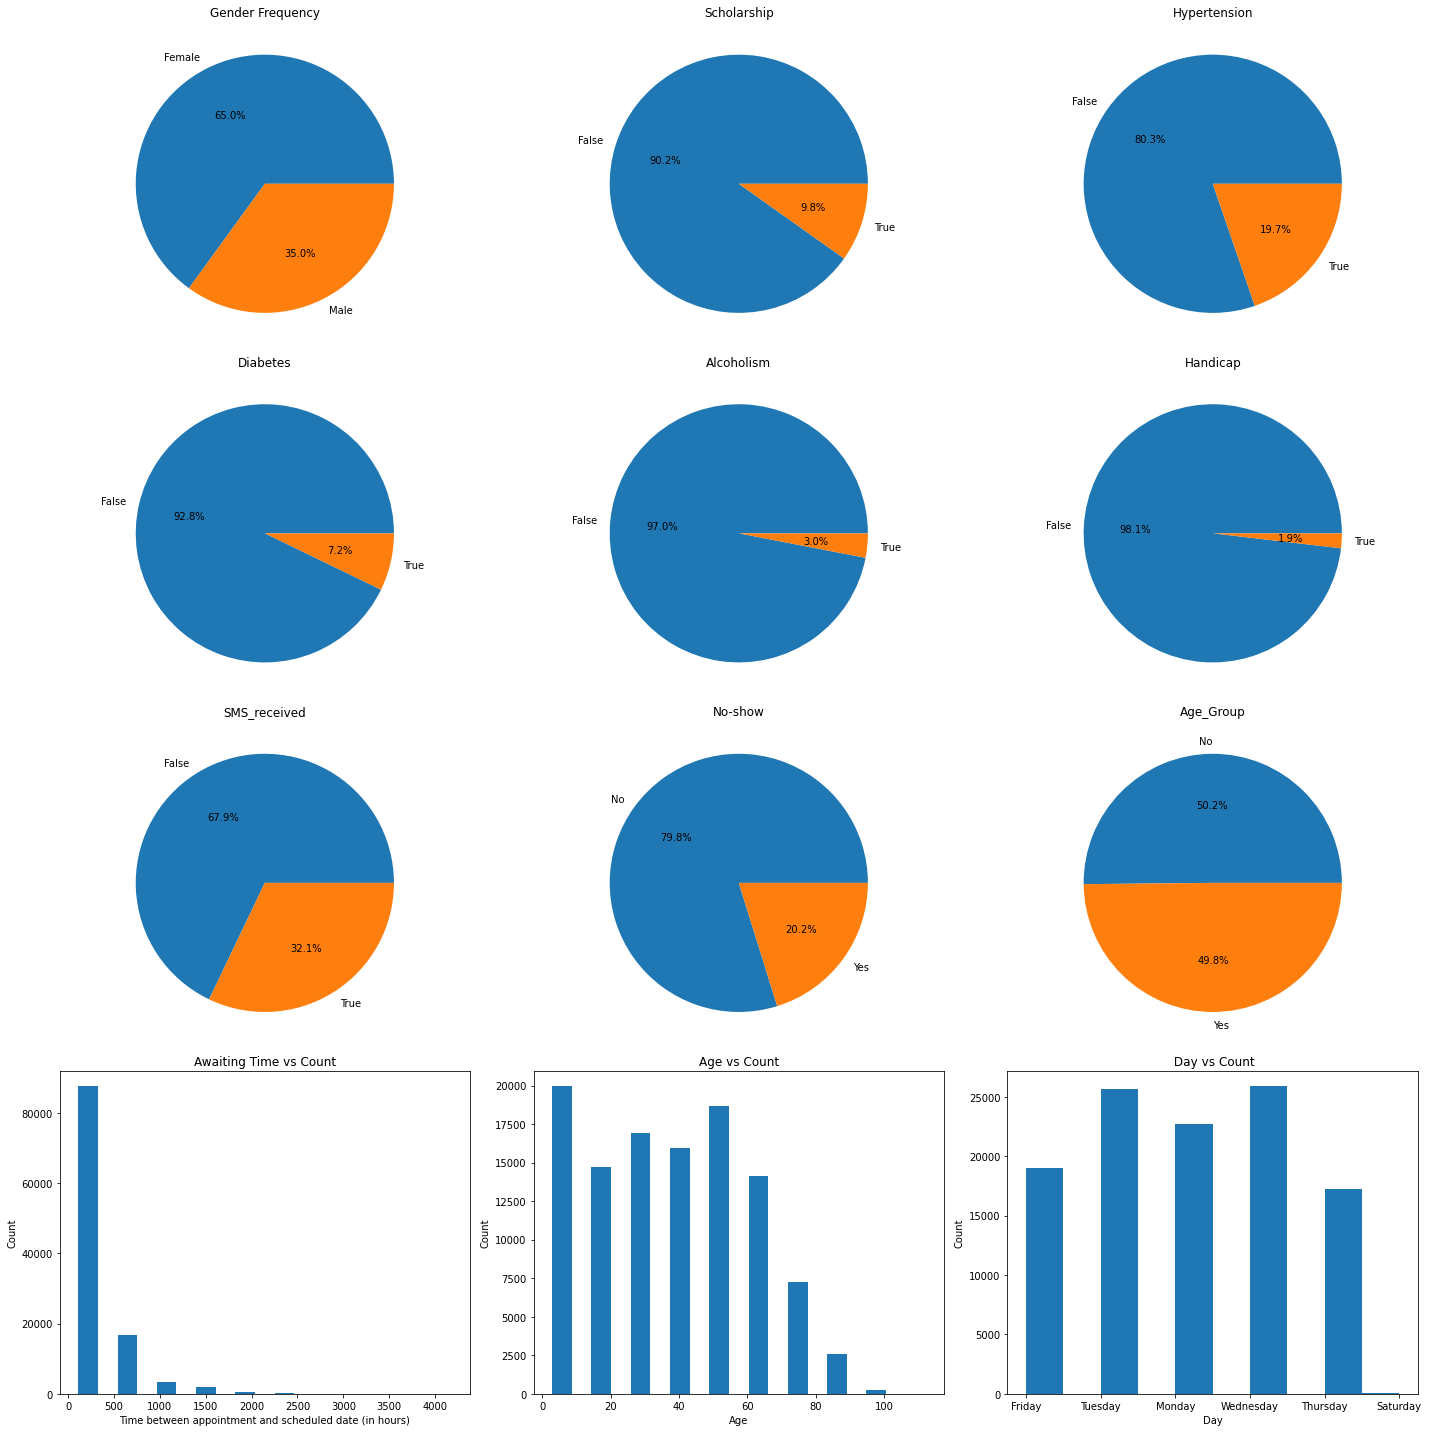

In [ ]:
#Visualizing Different Features

fig, ax = plt.subplots(nrows=4, ncols = 3, figsize=(20,20))

#Gender Plot

ax[0,0].pie([new_df.Gender.value_counts()['F'], new_df.Gender.value_counts()['M']], labels=['Female', 'Male'], autopct='%.1f%%')
ax[0,0].set_title('Gender Frequency')

#Scholarship

ax[0,1].pie([new_df.Scholarship.value_counts()[0], new_df.Scholarship.value_counts()[1]], labels=['False', 'True'], autopct='%.1f%%')
ax[0,1].set_title('Scholarship')

#Hypertension

ax[0,2].pie([new_df.Hypertension.value_counts()[0], new_df.Hypertension.value_counts()[1]], labels=['False', 'True'], autopct='%.1f%%')
ax[0,2].set_title('Hypertension')

#Diabetes

ax[1,0].pie([new_df.Diabetes.value_counts()[0], new_df.Diabetes.value_counts()[1]], labels=['False', 'True'], autopct='%.1f%%')
ax[1,0].set_title('Diabetes')

#Alcoholism

ax[1,1].pie([new_df.Alcoholism.value_counts()[0], new_df.Alcoholism.value_counts()[1]], labels=['False', 'True'], autopct='%.1f%%')
ax[1,1].set_title('Alcoholism')

#Handicap

ax[1,2].pie([new_df.Handicap.value_counts()[0], new_df.Handicap.value_counts()[1]], labels=['False', 'True'], autopct='%.1f%%')
ax[1,2].set_title('Handicap')

#SMS_received 

ax[2,0].pie([new_df.SMS_received.value_counts()[0], new_df.SMS_received.value_counts()[1]], labels=['False', 'True'], autopct='%.1f%%')
ax[2,0].set_title('SMS_received')

#No-Show

ax[2,1].pie([new_df['No-show'].value_counts()['No'], new_df['No-show'].value_counts()['Yes']], labels = ['No', 'Yes'], autopct='%.1f%%')
ax[2,1].set_title('No-show')

#Plotting age

ax[3,1].hist(np.array(new_df['Age']), density=False, rwidth=0.5)  # density=False would make counts
ax[3,1].set_ylabel('Count')
ax[3,1].set_xlabel('Age');
ax[3,1].set_title('Age vs Count');


#Plotting Awaiting Time

ax[3,0].hist(np.array(new_df['AwaitingTime']), density=False,rwidth=0.5)  # density=False would make counts
ax[3,0].set_ylabel('Count')
ax[3,0].set_xlabel('Time between appointment and scheduled date (in hours)');
ax[3,0].set_title('Awaiting Time vs Count');

#Age_Group

ax[2,2].pie([new_df['Age_Group'].value_counts()[0], new_df['Age_Group'].value_counts()[1]], labels = ['No', 'Yes'], autopct='%.1f%%')
ax[2,2].set_title('Age_Group')

#Appointment Day 

ax[3,2].hist(np.array(new_df['AppointmentDayName']), density=False)
ax[3,2].set_ylabel('Count')
ax[3,2].set_xlabel('Day');
ax[3,2].set_title(' Day vs Count');

fig.tight_layout()

plt.show()




Diiferent Features based on the label - No-show

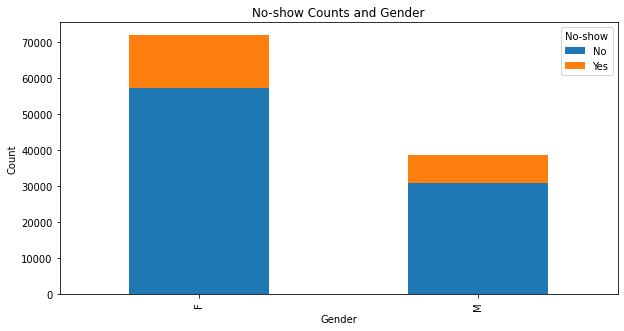

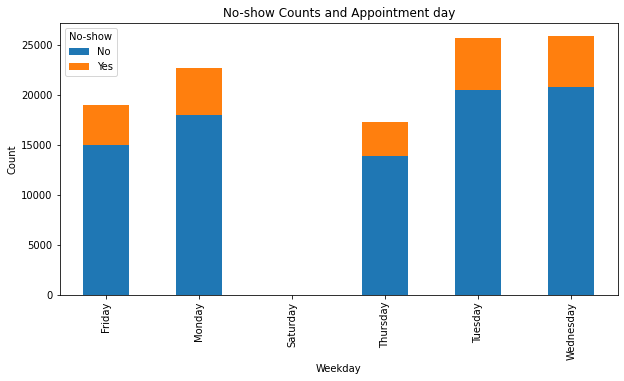

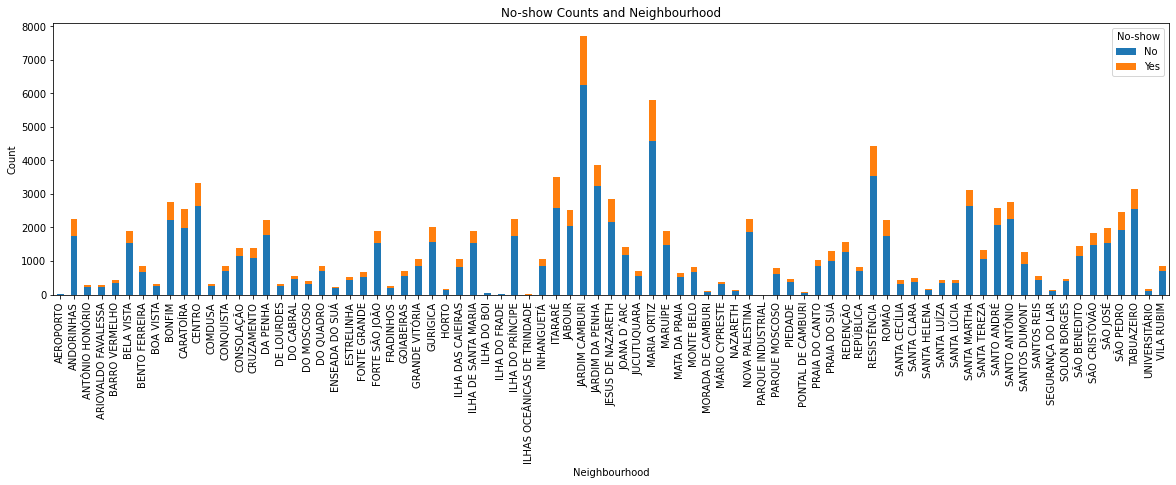

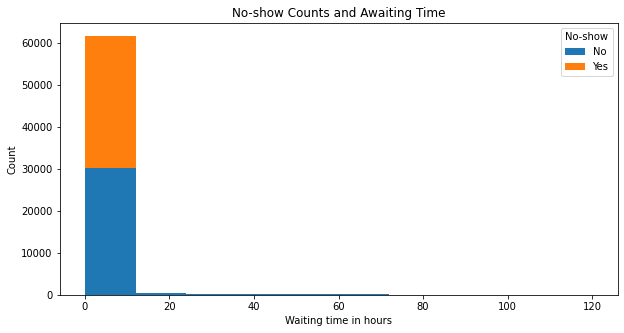

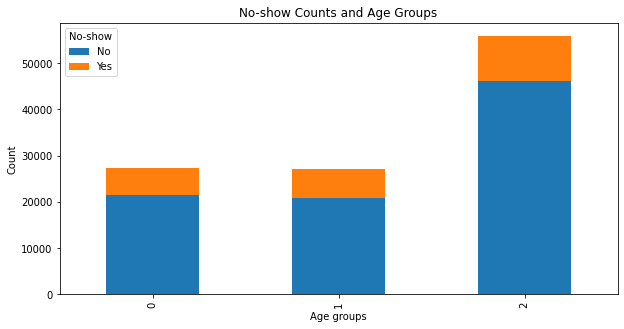

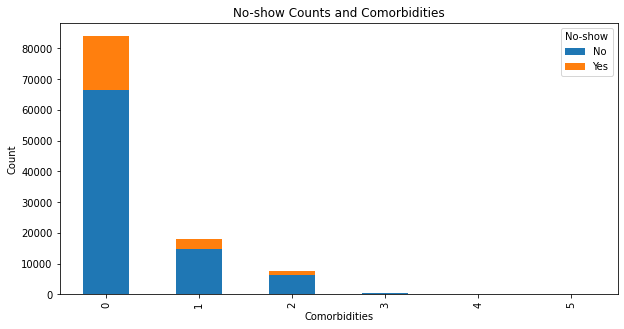

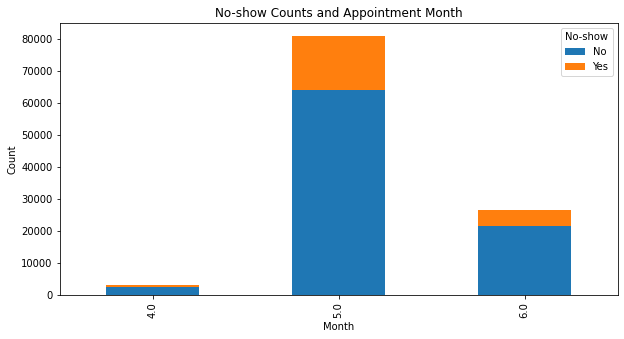

In [ ]:
cross_gender = pd.crosstab(new_df['Gender'], new_df['No-show'])

cross_gender.plot(kind='bar', stacked=True, figsize=(10,5))

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('No-show Counts and Gender')

plt.show()

print('\n\n\n\n')
#Contingency for Appointment day

cross_appointment_day = pd.crosstab(new_df['AppointmentDayName'], new_df['No-show'])
cross_appointment_day.plot(kind='bar', stacked = True, figsize=(10,5))

plt.xlabel('Weekday')
plt.ylabel('Count')
plt.title('No-show Counts and Appointment day')

plt.show()


print('\n\n\n\n')

#Contingency for Neighbourhood

cross_neigh = pd.crosstab(new_df['Neighbourhood'], new_df['No-show'])
cross_neigh.plot(kind='bar', stacked = True, figsize=(20,5))

plt.xlabel('Neighbourhood')
plt.ylabel('Count')
plt.title('No-show Counts and Neighbourhood')

plt.show()


print('\n\n\n\n')

#Contingency AwaitingTime

cross_time = pd.crosstab(new_df['AwaitingTime'], new_df['No-show'])
cross_time.plot(kind='hist', stacked = True, figsize=(10,5))

plt.xlabel('Waiting time in hours')
plt.ylabel('Count')
plt.title('No-show Counts and Awaiting Time')

plt.show()

print('\n\n\n\n')

#Contingency Age_Group

cross_age_group = pd.crosstab(new_df['Age_Group'], new_df['No-show'])
cross_age_group.plot(kind='bar', stacked = True, figsize=(10,5))

plt.xlabel('Age groups')
plt.ylabel('Count')
plt.title('No-show Counts and Age Groups')

plt.show()

print('\n\n\n\n')

#Contingency Comorbidities

cross_como = pd.crosstab(new_df['Comorbidities'], new_df['No-show'])
cross_como.plot(kind='bar', stacked = True, figsize=(10,5))

plt.xlabel('Comorbidities')
plt.ylabel('Count')
plt.title('No-show Counts and Comorbidities')

plt.show()

print('\n\n\n\n')

#Contingency Month

cross_month = pd.crosstab(new_df['AppointmentMonth']*6, new_df['No-show'])
cross_month.plot(kind='bar', stacked = True, figsize=(10,5))

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('No-show Counts and Appointment Month')

plt.show()

The age and awaiting time features do not follow a normal distribution so using Normalization instead of standardization. 

In [ ]:
new_df['Age'] = (new_df['Age']-new_df['Age'].min())/(new_df['Age'].max()-new_df['Age'].min()) #Normalized Age feature

new_df['AwaitingTime'] = (new_df['AwaitingTime']-new_df['AwaitingTime'].min())/(new_df['AwaitingTime'].max()-new_df['AwaitingTime'].min()) #Normalized AwaitingTime feature

In [ ]:
new_df.head(n=5)

,AppointmentID,ScheduledDate,ScheduledTime,ScheduledDayName,AppointmentDate,AppointmentDayName,AwaitingTime,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Age_Group,Comorbidities,AppointmentMonth,No-show
0,5642903,2016-04-29 18:38:08+00:00,18:38:08,Friday,2016-04-29 00:00:00+00:00,Friday,0.003589,F,0.53913,JARDIM DA PENHA,0,1,0,0,0,0,2,1,0.666667,No
1,5642503,2016-04-29 16:08:27+00:00,16:08:27,Friday,2016-04-29 00:00:00+00:00,Friday,0.003006,M,0.486957,JARDIM DA PENHA,0,0,0,0,0,0,2,0,0.666667,No
2,5642549,2016-04-29 16:19:04+00:00,16:19:04,Friday,2016-04-29 00:00:00+00:00,Friday,0.003048,F,0.53913,MATA DA PRAIA,0,0,0,0,0,0,2,0,0.666667,No
3,5642828,2016-04-29 17:29:31+00:00,17:29:31,Friday,2016-04-29 00:00:00+00:00,Friday,0.003321,F,0.069565,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0,0.666667,No
4,5642494,2016-04-29 16:07:23+00:00,16:07:23,Friday,2016-04-29 00:00:00+00:00,Friday,0.003001,F,0.486957,JARDIM DA PENHA,0,1,1,0,0,0,2,2,0.666667,No


Label Encoding and One Hot Encoding

In [ ]:
new_df['No-show'] = pd.Categorical(new_df['No-show']).codes #No is 0 and Yes is 1 for No-show variable

new_df['Gender'] = pd.Categorical(new_df['Gender']).codes #Female is 0 and Male is 1

#For neighbourhood encoding is based on Frequency and then min/max normalization

neighbourhood_counts = new_df['Neighbourhood'].value_counts()

map = {value: j for j, (value, count) in enumerate(neighbourhood_counts.iteritems())}

new_df['Neighbourhood_encoded'] = new_df['Neighbourhood'].map(map)

new_df['Neighbourhood_encoded'] = (new_df['Neighbourhood_encoded']-new_df['Neighbourhood_encoded'].min())/(new_df['Neighbourhood_encoded'].max()-new_df['Neighbourhood_encoded'].min()) #Normalized Neighbourhood_encoded feature


In [ ]:
#For AppointmentDayName encoding is based on Frequency and then min/max normalization


weekday_counts = new_df['AppointmentDayName'].value_counts()

map = {value: j for j, (value, count) in enumerate(weekday_counts.iteritems())}

new_df['AppointmentDay_encoded'] = new_df['AppointmentDayName'].map(map)

new_df['AppointmentDay_encoded'] = (new_df['AppointmentDay_encoded']-new_df['AppointmentDay_encoded'].min())/(new_df['AppointmentDay_encoded'].max()-new_df['AppointmentDay_encoded'].min()) #Normalized Neighbourhood_encoded feature


In [ ]:
new_df.head(n=5)

,AppointmentID,ScheduledDate,ScheduledTime,ScheduledDayName,AppointmentDate,AppointmentDayName,AwaitingTime,Gender,Age,Neighbourhood,...,Diabetes,Alcoholism,Handicap,SMS_received,Age_Group,Comorbidities,AppointmentMonth,No-show,Neighbourhood_encoded,AppointmentDay_encoded
0,5642903,2016-04-29 18:38:08+00:00,18:38:08,Friday,2016-04-29 00:00:00+00:00,Friday,0.003589,0,0.53913,JARDIM DA PENHA,...,0,0,0,0,2,1,0.666667,0,0.0375,0.6
1,5642503,2016-04-29 16:08:27+00:00,16:08:27,Friday,2016-04-29 00:00:00+00:00,Friday,0.003006,1,0.486957,JARDIM DA PENHA,...,0,0,0,0,2,0,0.666667,0,0.0375,0.6
2,5642549,2016-04-29 16:19:04+00:00,16:19:04,Friday,2016-04-29 00:00:00+00:00,Friday,0.003048,0,0.53913,MATA DA PRAIA,...,0,0,0,0,2,0,0.666667,0,0.6125,0.6
3,5642828,2016-04-29 17:29:31+00:00,17:29:31,Friday,2016-04-29 00:00:00+00:00,Friday,0.003321,0,0.069565,PONTAL DE CAMBURI,...,0,0,0,0,0,0,0.666667,0,0.9375,0.6
4,5642494,2016-04-29 16:07:23+00:00,16:07:23,Friday,2016-04-29 00:00:00+00:00,Friday,0.003001,0,0.486957,JARDIM DA PENHA,...,1,0,0,0,2,2,0.666667,0,0.0375,0.6


In [ ]:
all_features = new_df.columns.tolist()
print("Columns in new dataframe:", all_features)

Columns in new dataframe: ['AppointmentID', 'ScheduledDate', 'ScheduledTime', 'ScheduledDayName', 'AppointmentDate', 'AppointmentDayName', 'AwaitingTime', 'Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'Age_Group', 'Comorbidities', 'AppointmentMonth', 'No-show', 'Neighbourhood_encoded', 'AppointmentDay_encoded']


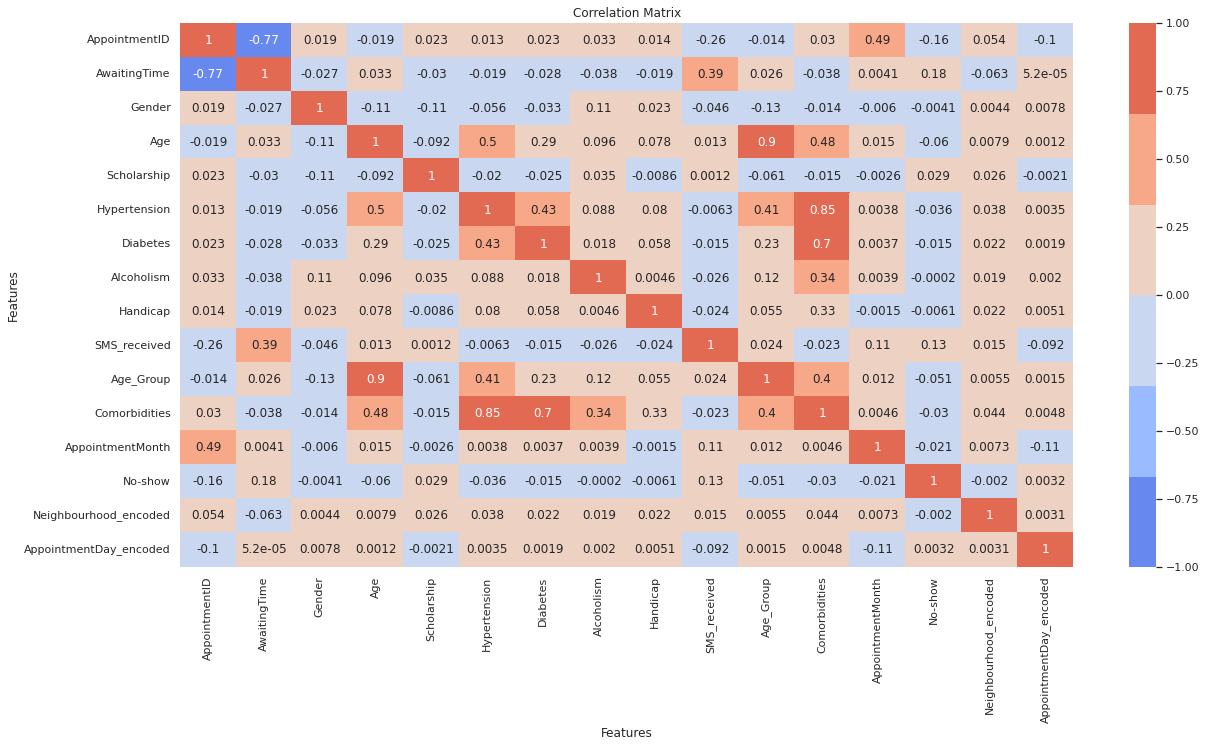

In [ ]:
#Creating a correlation matrix to visualize correlated features.

correlation1 = new_df.corr()

sns.set(rc={'figure.figsize':(20,10)})

colormap = sns.color_palette("coolwarm")

sns.heatmap(correlation1, annot=True, vmin=-1, vmax=1, cmap = colormap)


plt.xlabel('Features')
plt.ylabel('Features')
plt.title("Correlation Matrix")
plt.show()

Dropping AppointmentID and comorbodities features due to high correlation.

#Feature Selection and Data Split

In [ ]:
#Feature Selection and dropping correlated features

reduced_features = ['AwaitingTime', 'Gender', 'Age','Neighbourhood_encoded','Scholarship',
       'Hypertension', 'Diabetes', 'Alcoholism', 'Age_Group','Handicap','SMS_received','AppointmentMonth','AppointmentDay_encoded','No-show']

final_df = new_df[reduced_features] #Final dataframe with reduced features, which is used for training the models.

Training and Testing Data Preparation

In [ ]:
y = final_df['No-show']

x = final_df.drop('No-show', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=145)

#Machine Learning Model Training and Testing

Gaussian Naive Bayes Model.

In [ ]:
from sklearn.naive_bayes import GaussianNB

model_gnb = GaussianNB()

model_gnb.fit(x_train,y_train,)

gnb_pred = model_gnb.predict(x_test)

#print("Number of mislabeled instances out of total insrances %d : %d\n" % (x_test.shape[0], (y_test != gnb_pred).sum()))

cm_gnb = confusion_matrix(y_test, gnb_pred)

print("Classification metrics for Gaussian Naive Bayes model:\n")

print('Confusion Matrix: \n\n', cm_gnb)

total = sum(sum(cm_gnb))

#Accuracy function

#acc = (cm_gnb[0,0] + cm_gnb[1,1])/total

print("\nTesting Accuracy:", accuracy_score(y_test, gnb_pred))

#print("\nTesting Accuracy:", acc)

print('\nTraining Accuracy:', accuracy_score(y_train, model_gnb.predict(x_train)))

#print('\nMetrics:\n',classification_report(y_test, gnb_pred))

print("\nF1-Score:", f1_score(y_test, gnb_pred, average = 'weighted')) #Considering Weighted F1 Scored

sensitivity_gnb = cm_gnb[0,0]/(cm_gnb[0,0]+cm_gnb[0,1])
print('\nSensitivity:', sensitivity_gnb)

specificity_gnb = cm_gnb[1,1]/(cm_gnb[1,0]+cm_gnb[1,1])
print('\nSpecificity:', specificity_gnb)

Classification metrics for Gaussian Naive Bayes model:

Confusion Matrix: 

 [[24637  1790]
 [ 5802   929]]

Testing Accuracy: 0.7710356475058809

Training Accuracy: 0.7723735911487953

F1-Score: 0.7305091355961422

Sensitivity: 0.9322662428576834

Specificity: 0.13801812509285397


Notes for GNB: 
1. As the model's training and testing accuracy are not significantly different there is no overfitting present in the model.
2. The specificity of the model is very low compared to the sensitivity, which means we are not able to detect people missing appointments with a high accuracy.
3. The sensitivity is high, which means we are able to detect people who will keep their appointments more accurately.

Tuning the GNB model using GridSearchCV (Hyperparameter Tuning)



In [ ]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline(steps=[
                    ('pca', PCA()),
                    ('estimator', GaussianNB()),
                    ])

parameters_grid_num = {
    'estimator__var_smoothing': np.logspace(0,-9, num=100)
}

#model_gnb_grid = GridSearchCV(pipe, param_grid = parameters_grid_num, verbose=1, cv=10, n_jobs=-1)

model_gnb_grid = GridSearchCV(pipe, parameters_grid_num, scoring='f1_weighted', cv=10)

model_gnb_grid.fit(x_train, y_train)

#print("Number of mislabeled instances out of total insrances %d : %d" % (x_test.shape[0], (y_test != gnb_pred_grid).sum()))

cm_gnb_1 = confusion_matrix(y_test, model_gnb_grid.predict(x_test))

print("Classification metrics for Gaussian Naive Bayes model after Hyperparameter tuning:\n")


print('Confusion Matrix : \n\n', cm_gnb_1)

print("\nTesting Accuracy:", accuracy_score(y_test, model_gnb_grid.predict(x_test)))

print('\nTraining Accuracy:', accuracy_score(y_train, model_gnb_grid.predict(x_train)))

#print('\nMetrics:\n',classification_report(y_test, model_gnb_grid.predict(x_test)))

print("\nF1-Score:", f1_score(y_test, model_gnb_grid.predict(x_test), average = 'weighted'))

sensitivity_gnb_1 = cm_gnb_1[0,0]/(cm_gnb_1[0,0]+cm_gnb_1[0,1])
print('\nSensitivity:', sensitivity_gnb_1)

specificity_gnb_1 = cm_gnb_1[1,1]/(cm_gnb_1[1,0]+cm_gnb_1[1,1])
print('\nSpecificity:', specificity_gnb_1)


Classification metrics for Gaussian Naive Bayes model after Hyperparameter tuning:

Confusion Matrix : 

 [[25370  1057]
 [ 6166   565]]

Testing Accuracy: 0.7821641836057663

Training Accuracy: 0.7834505221797126

F1-Score: 0.7251463010537799

Sensitivity: 0.9600030272070231

Specificity: 0.08393997920071312


Notes for GNB after using GridSearchCV: 
1. As the model's training and testing accuracy are not significantly different there is no overfitting present in the model.
2. Compared to the GNB model the tuned model has a greater sensitivity however a lower specificity. This means we are able to predict the people who will keep their appointments more accurately that the base GNB model.

Support Vector Machine Model.

In [ ]:
from sklearn import svm

svm_model = svm.SVC(probability=True)

svm_model.fit(x_train, y_train)

svm_pred = svm_model.predict(x_test)

#print(classification_report(y_test, svm_pred))

cm_svm = confusion_matrix(y_test, svm_pred)

print("Classification metrics for SVM model:\n")

print('Confusion Matrix : \n\n', cm_svm)

print("\nTesting Accuracy:", accuracy_score(y_test, svm_pred))

print('\nTraining Accuracy:', accuracy_score(y_train, svm_model.predict(x_train)))

#print('\nMetrics:\n',classification_report(y_test, svm_pred))

print("\nF1-Score:", f1_score(y_test, svm_pred, average = 'weighted'))

sensitivity_svm = cm_svm[0,0]/(cm_svm[0,0]+cm_svm[0,1])
print('\nSensitivity:', sensitivity_svm)

specificity_svm = cm_svm[1,1]/(cm_svm[1,0]+cm_svm[1,1])
print('\nSpecificity:', specificity_svm)


Classification metrics for SVM model:

Confusion Matrix : 

 [[26427     0]
 [ 6731     0]]

Testing Accuracy: 0.7970022317389469

Training Accuracy: 0.7985213524971565

F1-Score: 0.7069691357947521

Sensitivity: 1.0

Specificity: 0.0


Notes for SVM:

1. As the F1-score for the minority class i.e. people who do not show up for their appointment is "0" the model is not able to identify any person who will miss their appointment.
2. As the F1-score for the majority class i.e. people who show up for their appointment is high the model is able to detect people who will show up for their appointment more accuraately.

In [ ]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier(max_depth=9)
tree_model.fit(x_train, y_train)

tree_pred = tree_model.predict(x_test)

#print(classification_report(y_test,tree_pred))

cm_tree = confusion_matrix(y_test, tree_pred)

print("Classification metrics for Decision Tree model:\n")

print('Confusion Matrix : \n\n', cm_tree)

print("\nTesting Accuracy:", accuracy_score(y_test, tree_pred))

print('\nTraining Accuracy:', accuracy_score(y_train, tree_model.predict(x_train)))

#print('\nMetrics:\n',classification_report(y_test, tree_pred))

print("\nF1-Score:", f1_score(y_test, tree_pred, average='weighted'))

sensitivity_tree = cm_tree[0,0]/(cm_tree[0,0]+cm_tree[0,1])
print('\nSensitivity:', sensitivity_tree)

specificity_tree = cm_tree[1,1]/(cm_tree[1,0]+cm_tree[1,1])
print('\nSpecificity:', specificity_tree)


Classification metrics for Decision Tree model:

Confusion Matrix : 

 [[26183   244]
 [ 6590   141]]

Testing Accuracy: 0.7938958923939924

Training Accuracy: 0.8030451866404715

F1-Score: 0.7130415399104161

Sensitivity: 0.9907670185794831

Specificity: 0.02094785321646115


Notes for Decision Tree: 
1. Because the Decision Tree was overfitting and presenting a training accuracy of 0.99 as compared to the testing accuracy of 0.64 the max_depth parameter was introduced in the training process to minimize overfitting.
2. The sensitivity for this model is very high, which means it is able to predict people who will show up for their appointment, however due to a low specificity people who will miss their appoitnments are not detected very accurately.

Feature ranking using Decision Tree algorithm.

Feature: 0, Score: 0.72785
Feature: 1, Score: 0.00900
Feature: 2, Score: 0.13576
Feature: 3, Score: 0.05060
Feature: 4, Score: 0.00944
Feature: 5, Score: 0.00449
Feature: 6, Score: 0.00518
Feature: 7, Score: 0.00603
Feature: 8, Score: 0.00459
Feature: 9, Score: 0.00584
Feature: 10, Score: 0.02314
Feature: 11, Score: 0.00257
Feature: 12, Score: 0.01551


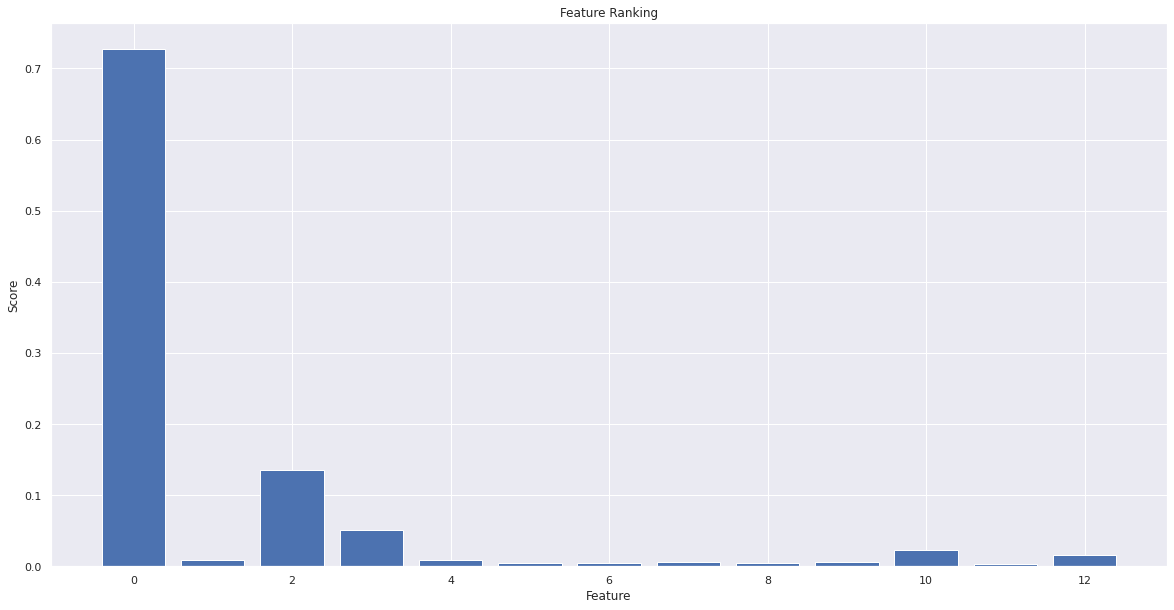

In [ ]:
#Feature importance

importance = tree_model.feature_importances_

# summarize feature importance

for i,v in enumerate(importance):

 print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel("Feature")
plt.ylabel("Score")
plt.title("Feature Ranking")
plt.show()


Tuning Decision Tree model by dimensionality reduction using important features.

In [ ]:
#Improving Decision tree based on top 5 best performing features.
reduced_features_dt = ['AwaitingTime', 'Age','Neighbourhood_encoded','Scholarship','SMS_received','AppointmentDay_encoded','No-show']

df_final_dt = new_df[reduced_features_dt]

y_tree_imp = final_df['No-show']

x_tree_imp = final_df.drop('No-show', axis=1)

x_train_tree, x_test_tree, y_train_tree, y_test_tree = train_test_split(x_tree_imp, y_tree_imp, test_size=0.3, random_state=10)

tree_model_1 = tree.DecisionTreeClassifier(max_depth=9)

tree_model_1.fit(x_train_tree, y_train_tree)

tree_pred_1 = tree_model_1.predict(x_test)

cm_tree_1 = confusion_matrix(y_test_tree, tree_pred_1)

print("Classification metrics for Decision Tree model after feature reduction:\n")

print('Confusion Matrix : \n\n', cm_tree_1)

print("\nTesting Accuracy:", accuracy_score(y_test_tree, tree_pred_1))

print('\nTraining Accuracy:', accuracy_score(y_train_tree, tree_model.predict(x_train_tree)))

#print('\nMetrics:\n',classification_report(y_test_tree, tree_pred_1))

print("\nF1-Score:", f1_score(y_test_tree, tree_pred_1, average = 'weighted'))

sensitivity_tree_1 = cm_tree_1[0,0]/(cm_tree_1[0,0]+cm_tree_1[0,1])
print('\nSensitivity:', sensitivity_tree_1)

specificity_tree_1 = cm_tree_1[1,1]/(cm_tree_1[1,0]+cm_tree_1[1,1])
print('\nSpecificity:', specificity_tree_1)


Classification metrics for Decision Tree model after feature reduction:

Confusion Matrix : 

 [[26299   214]
 [ 6574    71]]

Testing Accuracy: 0.7952831895771759

Training Accuracy: 0.7997751008168752

F1-Score: 0.7123060444690614

Sensitivity: 0.9919284879115905

Specificity: 0.010684725357411587


Notes for Decision Tree after feature reduction based on importance: 
1. The DT classifier performs better in terms of sensitivity and worse in terms of specificity after dimensionality reduction.

#Model Comparisons

Best performer out of GNB, SVM, and Decision Tree

In [ ]:
#Plot of different scores for the three algorithms

#Accuracy, Sensitivity, Specificity & F1 score


data = {'Name': ['GNB', 'SVM', 'Decision Tree', 'GNB_Tuned', 'Decision Tree Tuned'],
        'Testing Accuracy': [accuracy_score(y_test, gnb_pred), accuracy_score(y_test, svm_pred), accuracy_score(y_test, tree_pred),accuracy_score(y_test, model_gnb_grid.predict(x_test)), accuracy_score(y_test_tree, tree_pred_1)],
        'Sensitivity': [sensitivity_gnb,sensitivity_svm,sensitivity_tree,sensitivity_gnb_1,sensitivity_tree_1],
        'Specificity': [specificity_gnb,specificity_svm,specificity_tree,specificity_gnb_1, specificity_tree_1],
        'F1-Score': [f1_score(y_test, gnb_pred, average = 'weighted'), f1_score(y_test, svm_pred, average = 'weighted'), f1_score(y_test,tree_pred, average = 'weighted'), f1_score(y_test, model_gnb_grid.predict(x_test), average = 'weighted'), f1_score(y_test_tree, tree_pred_1, average = 'weighted')]
        }


df_comp = pd.DataFrame(data)
df_comp



,Name,Testing Accuracy,Sensitivity,Specificity,F1-Score
0,GNB,0.771036,0.932266,0.138018,0.730509
1,SVM,0.797002,1.000000,0.000000,0.706969
2,Decision Tree,0.793896,0.990767,0.020948,0.713042
3,GNB_Tuned,0.782164,0.960003,0.083940,0.725146
4,Decision Tree Tuned,0.795283,0.991928,0.010685,0.712306


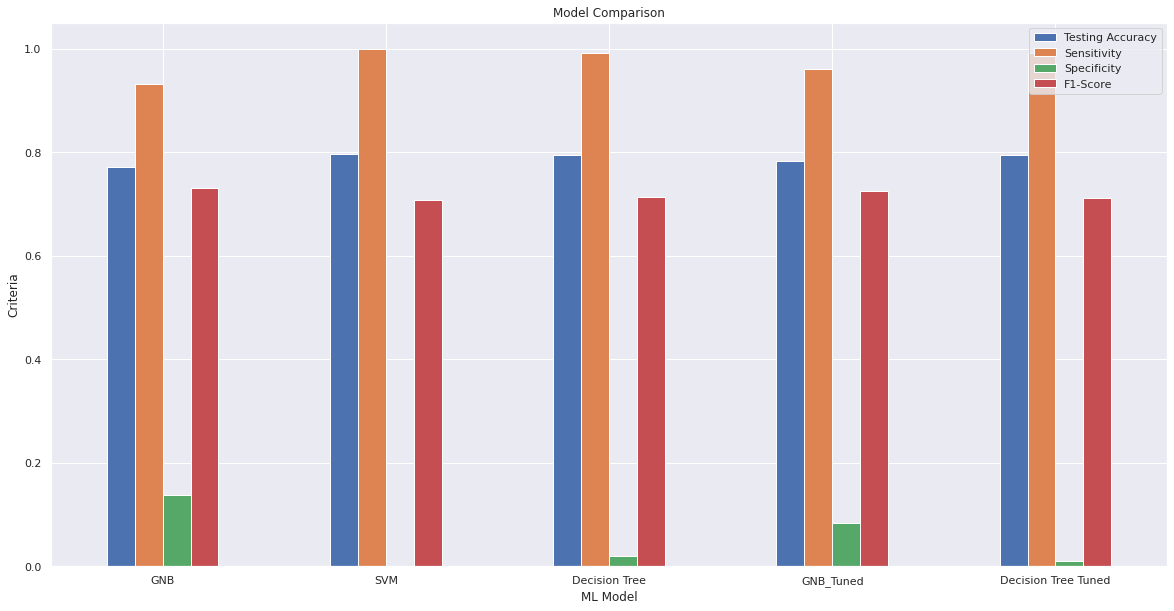

In [ ]:
df_comp.set_index('Name', inplace=True)

ax = df_comp.plot(kind='bar', rot=0)

ax.set_xlabel('ML Model')
ax.set_ylabel('Criteria')
ax.set_title('Model Comparison')
plt.show()

#ROC Analysis

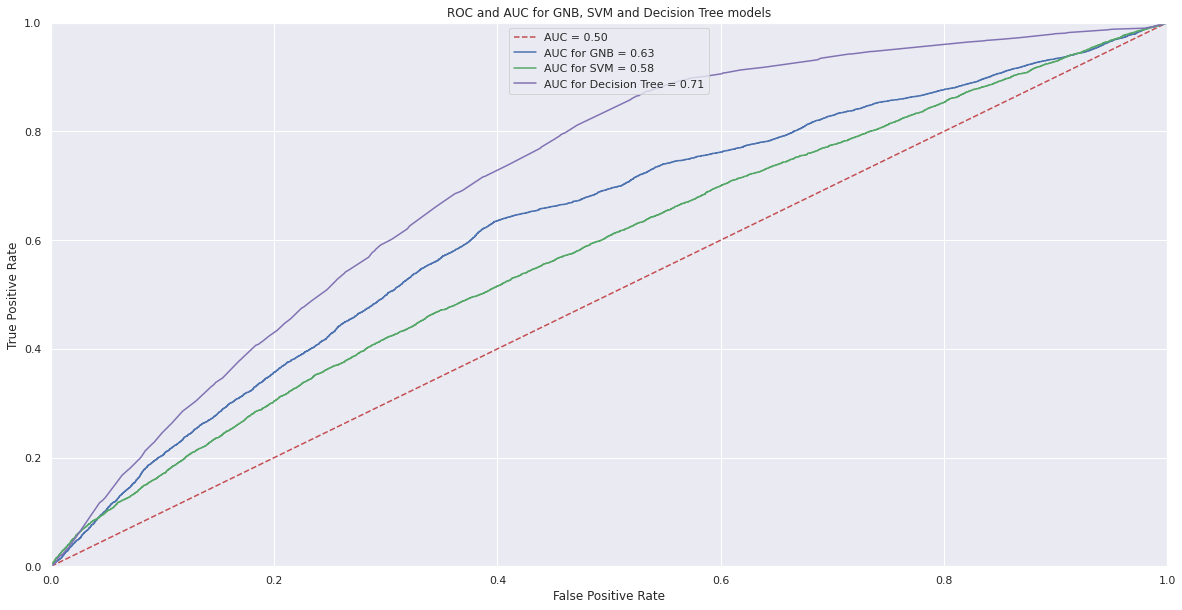

In [ ]:

models = [model_gnb_grid, svm_model, tree_model] #Comparing Tuned GNB, SVM, and Decision Tree

probs_gnb = models[0].predict_proba(x_test)
preds_gnb = probs_gnb[:,1]
f_p_r_gnb, t_p_r_gnb, threshold_gnb = metrics.roc_curve(y_test, preds_gnb)
roc_auc_gnb = metrics.auc(f_p_r_gnb, t_p_r_gnb)

probs_svm = models[1].predict_proba(x_test)
preds_svm = probs_svm[:,1]
f_p_r_svm, t_p_r_svm, threshold_svm = metrics.roc_curve(y_test, preds_svm)
roc_auc_svm = metrics.auc(f_p_r_svm, t_p_r_svm)

probs_tree = models[2].predict_proba(x_test)
preds_tree = probs_tree[:,1]
f_p_r_tree, t_p_r_tree, threshold_tree = metrics.roc_curve(y_test, preds_tree)
roc_auc_tree = metrics.auc(f_p_r_tree, t_p_r_tree)

plt.title('ROC and AUC for GNB, SVM and Decision Tree models')

plt.plot([0, 1], [0, 1],'r--', label = 'AUC = 0.50')

plt.plot(f_p_r_gnb, t_p_r_gnb, 'b', label = 'AUC for GNB = %0.2f' % roc_auc_gnb)

plt.plot(f_p_r_svm, t_p_r_svm, 'g', label = 'AUC for SVM = %0.2f' % roc_auc_svm)

plt.plot(f_p_r_tree, t_p_r_tree, 'm', label = 'AUC for Decision Tree = %0.2f' % roc_auc_tree)

plt.legend(loc = 'upper center')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()



#Additional methods for increasing GNB performance.

Because our data is imbalanced oversampling the underepresented class.


In [ ]:
from sklearn.utils import resample

y = final_df['No-show']

x = final_df.loc[:, final_df.columns != 'No-show']

x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x, y, test_size=0.3, random_state=150)

X_new = pd.concat([x_train_new, y_train_new], axis=1)  #Concatenating training data with target labels

#Separating Majority and minority class

show = X_new[X_new['No-show']==0]

no_show = X_new[X_new['No-show']==1]

#Upsampling No_show class

no_show_upsampled = resample(no_show,
                          replace=True, # sample with replacement
                          n_samples=len(show), # match number in majority class
                          random_state=10)


#Concatenating majority class and upsampled minority class
X_upsampled = pd.concat([show, no_show_upsampled])


X_upsampled['No-show'].value_counts()


0    61843
1    61843
Name: No-show, dtype: int64

In [ ]:
#Testing after Upsampling minority class

model1 = GaussianNB()

Y_train = X_upsampled['No-show']

X_train = X_upsampled.drop('No-show', axis=1)

model1.fit(X_train,Y_train)

cm_gnb_2 = confusion_matrix(y_test_new, model1.predict(x_test_new))

#print('\n',classification_report(y_test, gnb_pred))

print('Confusion Matrix : \n\n', cm_gnb_2)

print("\nTesting Accuracy:", accuracy_score(y_test_new, model1.predict(x_test_new)))

print('\nTraining Accuracy:', accuracy_score(Y_train, model1.predict(X_train)))

#print('\nMetrics:\n',classification_report(y_test, model1.predict(x_test)))

print("\nF1-Score:", f1_score(y_test_new, model1.predict(x_test_new), average='weighted'))

sensitivity_model1 = cm_gnb_2[0,0]/(cm_gnb_2[0,0] + cm_gnb_2[0,1])
print('\nSensitivity:', sensitivity_model1)

specificity_model1 = cm_gnb_2[1,1]/(cm_gnb_2[1,0] + cm_gnb_2[1,1])
print('\nSpecificity:', specificity_model1)



Confusion Matrix : 

 [[17713  8651]
 [ 3094  3700]]

Testing Accuracy: 0.6457868387719404

Training Accuracy: 0.609875006063742

F1-Score: 0.676329421497929

Sensitivity: 0.6718631467152177

Specificity: 0.5445981748601707


In [ ]:
#GridSearchCV after upsampling

from sklearn.model_selection import GridSearchCV

parameters_grid_num = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

model_gnb_grid_1 = GridSearchCV(estimator=GaussianNB(), param_grid = parameters_grid_num, verbose=1, cv=10, n_jobs=-1)

model_gnb_grid_1.fit(X_train,Y_train)

gnb_pred_grid_1 = model_gnb_grid_1.predict(x_test_new)

cm_gnb_3 = confusion_matrix(y_test_new, gnb_pred_grid_1)

#print('\n',classification_report(y_test, gnb_pred))

print('Confusion Matrix : \n\n', cm_gnb_3)

print("\nTesting Accuracy:", accuracy_score(y_test_new, gnb_pred_grid_1))

print('\nTraining Accuracy:', accuracy_score(Y_train, model_gnb_grid_1.predict(X_train)))

#print('\nMetrics:\n',classification_report(y_test_new, gnb_pred_grid_1))

print("\nF1-Score:", f1_score(y_test_new, gnb_pred_grid_1, average = 'weighted'))

sensitivity_model2 = cm_gnb_3[0,0]/(cm_gnb_3[0,0] + cm_gnb_3[0,1])
print('\nSensitivity:', sensitivity_model2)

specificity_model2 = cm_gnb_3[1,1]/(cm_gnb_3[1,0] + cm_gnb_3[1,1])
print('\nSpecificity:', specificity_model2)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Confusion Matrix : 

 [[17654  8710]
 [ 3097  3697]]

Testing Accuracy: 0.6439170034380843

Training Accuracy: 0.6096324563814821

F1-Score: 0.6747528100756902

Sensitivity: 0.6696252465483234

Specificity: 0.5441566087724463


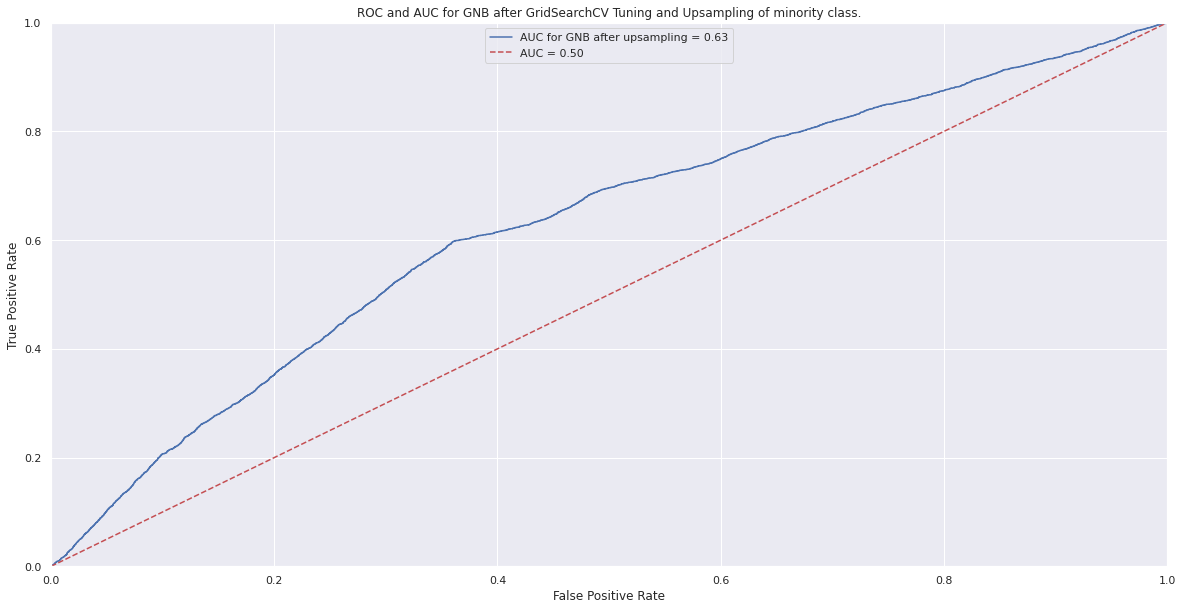

In [ ]:
probs_gnb_1 = model_gnb_grid_1.predict_proba(x_test)
preds_gnb_1 = probs_gnb_1[:,1]
f_p_r_gnb_1, t_p_r_gnb_1, threshold_gnb_1 = metrics.roc_curve(y_test, preds_gnb_1)
roc_auc_gnb_1 = metrics.auc(f_p_r_gnb_1, t_p_r_gnb_1)

plt.plot(f_p_r_gnb_1, t_p_r_gnb_1, 'b', label = 'AUC for GNB after upsampling = %0.2f' % roc_auc_gnb_1)

plt.plot([0, 1], [0, 1],'r--', label = 'AUC = 0.50')

plt.title('ROC and AUC for GNB after GridSearchCV Tuning and Upsampling of minority class.')

plt.legend(loc = 'upper center')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()


Notes for GNB after using GridSearchCV and upsampling the minority class: 
1. The overall accuracy of the model has decreased, however, the F1-score for the minority class was doubled and the specificity of the model has increased to over 0.55. This means that we are better able to detect people who will miss their appointments as compared to the previous models.

SVM after upsampling

In [ ]:
from sklearn import svm

svm_model = svm.SVC(probability=True)

svm_model.fit(X_train,Y_train)

svm_pred = svm_model.predict(x_test_new)

#print(classification_report(y_test, svm_pred))

cm_svm = confusion_matrix(y_test_new, svm_pred)

print("Classification metrics for SVM model:\n")

print('Confusion Matrix : \n\n', cm_svm)

print("\nTesting Accuracy:", accuracy_score(y_test_new, svm_pred))

print('\nTraining Accuracy:', accuracy_score(Y_train, svm_model.predict(X_train)))

#print('\nMetrics:\n',classification_report(y_test, svm_pred))

print("\nF1-Score:", f1_score(y_test_new, svm_pred, average = 'weighted'))

sensitivity_svm = cm_svm[0,0]/(cm_svm[0,0]+cm_svm[0,1])
print('\nSensitivity:', sensitivity_svm)

specificity_svm = cm_svm[1,1]/(cm_svm[1,0]+cm_svm[1,1])
print('\nSpecificity:', specificity_svm)